# Objetivo - Fazer um comparativo do poder de compra do gás em relação ao salário mínimo de cada ano

In [1]:
import os
import csv
import time
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from glob import glob
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options



# Preparando dados

## GLP

### Coletando dados

In [2]:
def downloading_data():
  url = 'https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-por-revenda'

  options= Options()
  options.add_experimental_option("prefs", {'download.default_directory':r"C:\dados\GasHistorica\Data"}) #Pasta de destino dos downloads (Alterar se necessário)

  driver = webdriver.Chrome(options=options)
  driver.get(url=url)
  time.sleep(2)

  driver.find_elements(By.ID, 'btnCollapse')[2].click() # Clicando em "Recursos"

  lista_de_recursos = driver.find_elements(By.CLASS_NAME, "col-10") # Lista de todos os recursos
  
  # Loop iterando os elementos em busca dos que contém GLP.

  for divisoria in lista_de_recursos: 
    if 'GLP' in divisoria.text:
      divisoria.find_element(By.ID, 'btnDownloadUrl').click() #Clicando no botão de download para cada elemento que contém "GLP"
      time.sleep(20)


  driver.quit()

In [3]:
#downloading_data()

________

### Criação e limpeza e tratamento dos dataframe de gás

In [4]:
# Para criar um único dataframe com todos os dados recolhidos, criamos uma lista com o glob() que nos retorna o caminho dos arquivos.

In [5]:
path = r'C:\dados\GasHistorica\Data'

all_files = glob(os.path.join(path, "*.csv"))

In [6]:
# Com isso, lemos cada um dos caminhos do csv e passamos para o concat, unindo todos os DF's em um único.

gas_dataframe = pd.concat((pd.read_csv(file,sep=';', encoding='latin-1') for file in all_files))

C:\Users\peyq\AppData\Local\Temp\ipykernel_4072\691533866.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gas_dataframe = pd.concat((pd.read_csv(file,sep=';', encoding='latin-1') for file in all_files))


In [7]:
# Como os arquivos do ano de 2022 estão em dois formatos, csv's mensais e o primeiro semestre de 2022, algumas entradas estão repetidas (2022.1 ~ 2022.6).
# Para evitar essas repetições, droparei as linhas repetidas:

In [8]:
gas_dataframe.loc[gas_dataframe.duplicated()] 

,ï»¿Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira,Regiao - Sigla
0,SE,SP,SAO VICENTE,CONSIGAZ DISTRIBUIDORA DE GÃS LTDA.,01.597.589/0003-81,RUA MANOEL DE ABREU,790,QUADRA 108,CIDADE NAUTICA,11355-400,GLP,03/01/2022,"97,99",NaN,R$ / 13 kg,CONSIGAZ,NaN
1,N,AC,RIO BRANCO,AUTO POSTO AMAPA - EIRELI,00.529.581/0001-53,VIA CHICO MENDES,3570,NaN,AREAL,69906-119,GLP,03/01/2022,115,NaN,R$ / 13 kg,FOGAS,NaN
2,N,AC,RIO BRANCO,AUTO POSTO ACAUAN LTDA,00.524.999/0001-78,RODOVIA AC 40,1800,NaN,VILA ACRE,69902-450,GLP,03/01/2022,110,NaN,R$ / 13 kg,AMAZONGÃS,NaN
3,N,AC,RIO BRANCO,AUTO POSTO CANINDE LTDA,05.442.544/0001-27,RODOVIA AC 40,3206,KM 07,VILA ACRE,69902-450,GLP,03/01/2022,115,NaN,R$ / 13 kg,AMAZONGÃS,NaN
4,N,AC,RIO BRANCO,AUTO POSTO AEROPORTO LTDA,14.294.227/0001-00,V CHICO MENDES,2583,NaN,COMARA,69906-326,GLP,03/01/2022,115,NaN,R$ / 13 kg,AMAZONGÃS,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100128,S,PR,CAMPO MOURAO,M. J. ALEXANDRE - GAS LTDA,37.223.162/0001-07,RUA ANTONIO JUSTINO FERREIRA,623,NaN,JARDIM PAULISTA,87310-550,GLP,30/06/2022,115,NaN,R$ / 13 kg,BRANCA,NaN
100129,S,RS,NOVO HAMBURGO,J ALECIO CARDOSO,36.682.734/0001-45,RUA FLORENCA,820,NaN,CANUDOS,93542-061,GLP,30/06/2022,105,NaN,R$ / 13 kg,ULTRAGAZ,NaN
100130,SE,MG,MONTES CLAROS,W DIAS GAS EIRELI,34.473.925/0001-71,RUA MANOEL BANDEIRA,815,NaN,PLANALTO,39404-035,GLP,30/06/2022,128,NaN,R$ / 13 kg,ULTRAGAZ,NaN
100131,NE,BA,IRECE,COSTA MENDONCA DERIVADOS DE PETROLEO LTDA,19.584.110/0001-76,AVENIDA PRIMEIRO DE JANEIRO,275,TERREO,CENTRO,44900-000,GLP,30/06/2022,107,NaN,R$ / 13 kg,BAHIANA,NaN


In [9]:
gas_dataframe = gas_dataframe.drop_duplicates()

In [10]:
# No index atual, temos vários números repetidos, pois os números se repetem a cada tabela. 
# Para consertar isso, iremos resetar o index, atribuindo assim uma única posição a cada elemento,
# e dropando a coluna para que ela não continue no DF.

In [11]:
gas_dataframe = gas_dataframe.reset_index(drop=True)

In [12]:
gas_dataframe.columns

Index(['ï»¿Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira', 'Regiao - Sigla'],
      dtype='object')

In [13]:
# Após identificar as colunas, substituo as colunas relevantes que contém algum caractere que possa atrapalhar na manipulação dos dados.
# Os espaços são substituidos por _ , acentuações removidas (se existirem), além da padronização para letras minúsculas.

In [14]:
gas_dataframe = gas_dataframe.rename({'Data da Coleta': 'data',
                            'Estado - Sigla': 'estado',
                            'ï»¿Regiao - Sigla':'regiao',
                            'Valor de Venda':'valor_venda',
                            'Valor de Compra':'valor_compra',
                            'Revenda':'revenda',
                            'CNPJ da Revenda':'cnpj_revenda',
                            'Nome da Rua':'nome_rua',}, axis=1)

In [15]:
gas_dataframe['Unidade de Medida'].value_counts() # Verificação se a unidade de medida varia.

R$ / 13 kg    5736458
R$ / litro      14723
R$ / m³          1257
Name: Unidade de Medida, dtype: int64

In [16]:
# Padronizando a unidade de medida, deixando apenas o botijão (13kg)

gas_dataframe = gas_dataframe[gas_dataframe['Unidade de Medida'] == "R$ / 13 kg"]

In [17]:
# Transformando a data de coleta em um DateTime para facilitar operações.

gas_dataframe['data'] = pd.to_datetime(gas_dataframe['data'], format='%d/%m/%Y') 

In [18]:
# Corrigindo a coluna de valor de venda, que acusava tipos diferentes (int + str), por conta da padronização decimal brasileira.
# Aqui, substituo a "," por "." nas strs e em seguida transformo todos os valores em float, padronizando-os.

gas_dataframe['valor_venda'] = pd.to_numeric(gas_dataframe['valor_venda'].apply(lambda x: x.replace(',', '.')))

In [19]:
gas_dataframe.head(2)

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira,Regiao - Sigla
0,N,PA,BELEM,AUTO POSTO BELEM LTDA,05.825.216/0001-00,AVENIDA PEDRO ALVARES CABRAL,S/N,ESQ. COM AV. TAVARES BASTOS,MARAMBAIA,66613-150,GLP,2022-10-03,119.00,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA,NaN
1,N,PA,BELEM,IRMAOS TEIXEIRA LTDA,04.976.718/0003-30,AVENIDA PEDRO ALVARES CABRAL,3800,NaN,SACRAMENTA,66120-620,GLP,2022-10-03,115.99,NaN,R$ / 13 kg,BAHIANA,NaN


In [20]:
# Com isso, nossa limpeza inicial está completa. Caso veja a necessidade durante o decorrer da análise, adicionarei os próximos passos da limpeza abaixo.

____________

## Salário Mínimo

### Coletando dados

In [21]:
url_sm = 'http://www.ipeadata.gov.br/exibeserie.aspx?stub=1&serid1739471028=1739471028'

In [22]:
# Os dados do salário mínimo estão disponíveis no site do IPEA de forma mais simplificada do que no portal de dados do governo (devido ao JavaScript usado no portal),
# então coletar esses dados pode ser realizado de forma muito mais simples, usando apenas o método get e lendo o conteúdo da página. Ali, identificamos a tabela que precisamos:

In [23]:
pag_html = requests.get(url_sm)
df_list = pd.read_html(pag_html.text)

In [24]:
df_list[2]

,0,1
0,Data,Salário mínimo vigente
1,1940.07,87273E-14
2,1940.08,87273E-14
3,1940.09,87273E-14
4,1940.10,87273E-14
...,...,...
986,2022.08,"1.212,00"
987,2022.09,"1.212,00"
988,2022.10,"1.212,00"
989,2022.11,"1.212,00"


### Criação e limpeza do dataframe de salário

In [25]:
# Atribuindo os headers das colunas em seus devidos lugares

In [26]:
salario_geral = df_list[2].rename(columns=df_list[2].iloc[0]).drop(0)
salario_geral.head()

,Data,Salário mínimo vigente
1,1940.07,87273E-14
2,1940.08,87273E-14
3,1940.09,87273E-14
4,1940.10,87273E-14
5,1940.11,87273E-14


In [27]:
# Prosseguimos com a limpeza, alterando a data para o formato correto e atribuindo o resultado como index.
# Aproveito também para trocar o nome da coluna salário, de forma que a acentuação e espaços não atrapalhem nas consultas.

In [28]:
salario_geral['Data'] = pd.to_datetime(salario_geral['Data'], format='%Y/%m')
salario_geral = salario_geral.set_index('Data')
salario_geral = salario_geral.rename({'Salário mínimo vigente':'Salario'},axis=1)


In [29]:
# Aqui, faço um slice no salário usando como data de inicio o mês que obtemos a primeira média de preços com os registros do gás (Feito mais abaixo, na seção _________).
# Além disso, os números estão despadronizados, alguns com 0's a mais, os últimos que chegam aos milhares contam com . e , na mesma string
# Então, aproveito para tratar e remover os centavos 0's a mais, transformando-o para int.

In [30]:
salario_selecionado = salario_geral.loc['2004-05':'2022-10'].copy()
salario_selecionado['Salario'] = (salario_selecionado.Salario.apply(lambda x: x[:-2].replace((','), '')))
salario_selecionado['Salario'] = pd.to_numeric(salario_selecionado.Salario.apply(lambda x: x.replace('.', '')))

In [31]:
salario_selecionado.Salario

Data
2004-05-01     260
2004-06-01     260
2004-07-01     260
2004-08-01     260
2004-09-01     260
              ... 
2022-06-01    1212
2022-07-01    1212
2022-08-01    1212
2022-09-01    1212
2022-10-01    1212
Name: Salario, Length: 222, dtype: int64

In [32]:
#
# Ideia: Plotar por cima do grafico abaixo um segundo com marcadores nos momentos que ocorre aumento salarial (coluna separada identificando? outro dataset?)
# Cuidado: Poluição visual. Talvez seja necessário remover o grid

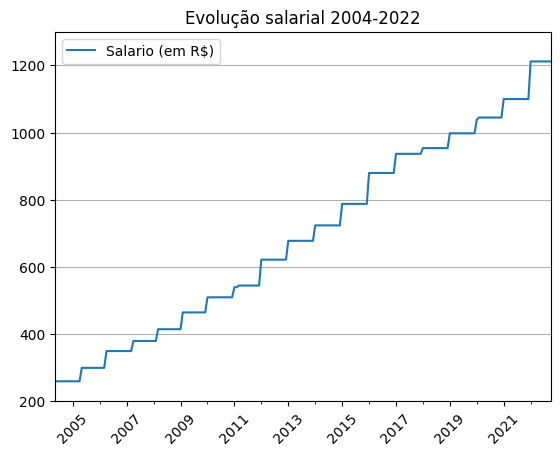

In [33]:
salario_selecionado.plot(kind='line', ylim=(200,1300))
plt.title('Evolução salarial 2004-2022')
plt.grid(which='major', axis='y')

plt.xlabel('')
plt.xticks(rotation=45)

plt.legend(['Salario (em R$)'])
plt.show()

In [34]:
# Podemos observar que o crescimento de salários ocorre de maneira irregular ao longo dos anos, variando até mesmo o intervalo de tempo em que é aumentado.
# Um claro exemplo disso ocorre entre 2010 e 2011, onde o salário é aumentado duas vezes em um intervalo de 4 meses (Em Janeiro e março ocorrem aumentos),
# para se estabilizar novamente até o final daquele ano.

In [35]:
salario_selecionado['2010-11':'2011-03']

,Salario
Data,
2010-11-01,510
2010-12-01,510
2011-01-01,540
2011-02-01,540
2011-03-01,545


_________

## Médias mensais - GLP e Salário 

In [36]:
gas_dataframe.head()

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira,Regiao - Sigla
0,N,PA,BELEM,AUTO POSTO BELEM LTDA,05.825.216/0001-00,AVENIDA PEDRO ALVARES CABRAL,S/N,ESQ. COM AV. TAVARES BASTOS,MARAMBAIA,66613-150,GLP,2022-10-03,119.00,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA,NaN
1,N,PA,BELEM,IRMAOS TEIXEIRA LTDA,04.976.718/0003-30,AVENIDA PEDRO ALVARES CABRAL,3800,NaN,SACRAMENTA,66120-620,GLP,2022-10-03,115.99,NaN,R$ / 13 kg,BAHIANA,NaN
2,N,PA,BELEM,SUPERCENTRO POSTOS DE SERVIÃO LTDA,05.303.828/0001-32,AVENIDA ALMIRANTE BARROSO,1814,B,MARCO,66093-020,GLP,2022-10-03,130.00,NaN,R$ / 13 kg,NACIONAL GÃS BUTANO,NaN
3,N,PA,BELEM,POSTO GIRASSOL LTDA,01.087.686/0001-62,RODOVIA AUGUSTO MONTENEGRO,1800,NaN,NOVA MARAMBAIA,66623-590,GLP,2022-10-03,110.00,NaN,R$ / 13 kg,ULTRAGAZ,NaN
4,N,PA,BELEM,POSTO ALIANCA EIRELI,14.685.994/0001-31,RODOVIA ARTHUR BERNARDES,151,ESQ PEDRO A CABRAL,SACRAMENTA,66825-000,GLP,2022-10-03,119.50,NaN,R$ / 13 kg,SUPERGASBRAS ENERGIA,NaN


In [37]:
valor_glp_meses = gas_dataframe.resample("M", on='data').mean().reset_index()
valor_glp_meses

,data,valor_venda
0,2004-05-31,30.333714
1,2004-06-30,30.298823
2,2004-07-31,30.330043
3,2004-08-31,30.224504
4,2004-09-30,30.106575
...,...,...
217,2022-06-30,113.537009
218,2022-07-31,112.905352
219,2022-08-31,112.277794
220,2022-09-30,113.160335


In [38]:
# Verificando se algum dos valores ficou faltante, percebemos que um mês está com NaN:
valor_glp_meses.loc[valor_glp_meses.valor_venda.isna()]

,data,valor_venda
196,2020-09-30,NaN


In [39]:
# O ano de 2020 nesse conjunto de dados apresenta um número muito menor de registros, e o mês de setembro inteiro (09)
# não teve registros. Podemos observar isso fazendo uma query no dataframe geral, que não nos retorna nenhum resultado:

gas_dataframe[(gas_dataframe.data.dt.month == 9) & (gas_dataframe.data.dt.year == 2020)]

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira,Regiao - Sigla


In [40]:
# Para contornar o problema, preencheremos o valor de acordo com valor anterior ao mesmo:

valor_glp_meses = valor_glp_meses.fillna(method='bfill')

valor_glp_meses[valor_glp_meses.valor_venda.notna() == False] # Mostrando que não temos mais valores nulos

,data,valor_venda


In [41]:
# Agora que reduzimos nosso conjunto à média mensal do gás, podemos relacionar isso com os valores mensais do salário mínimo.

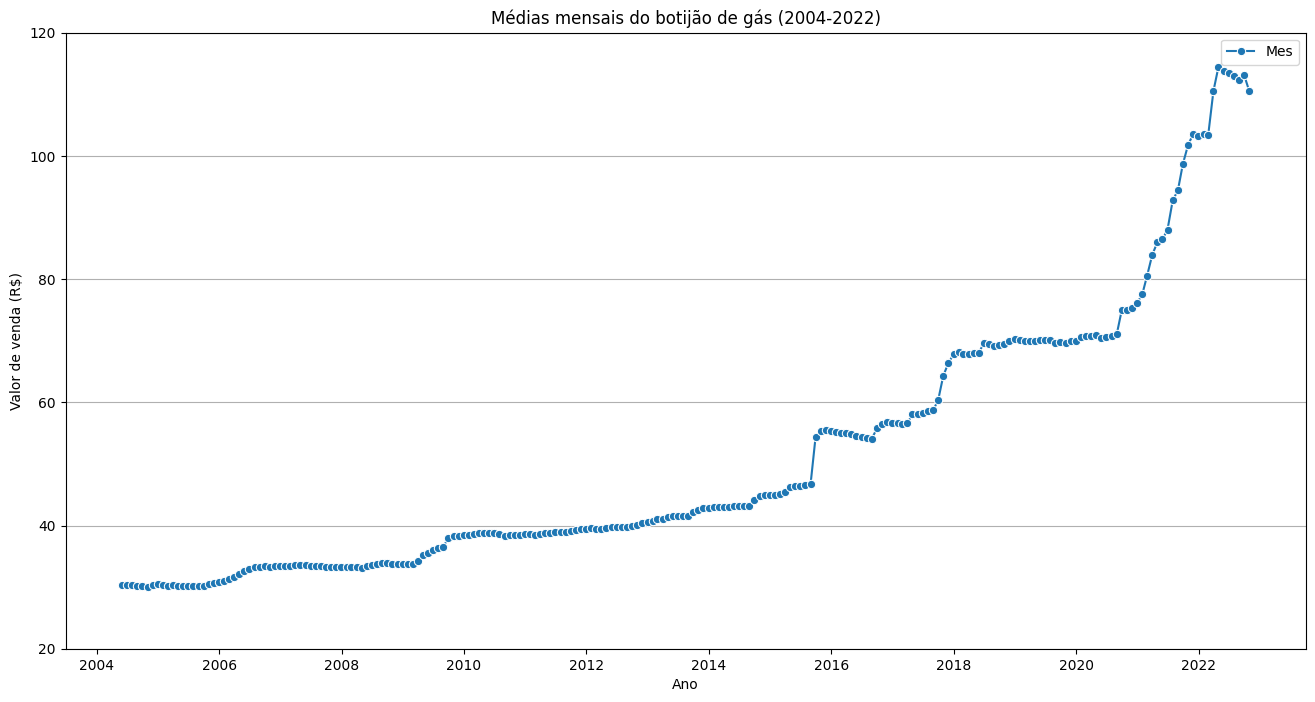

In [42]:
# Plotando a média do valor de venda em todo o território nacional no período de 2004 a 2020.

ax = plt.subplots(figsize=(16,8))
plt.title('Médias mensais do botijão de gás (2004-2022)')
plt.xlabel('Ano')
plt.ylabel('Valor de venda (R$)')
plt.grid(axis='y')
plt.ylim((20, 120))
sns.lineplot(valor_glp_meses, x='data', y='valor_venda', marker='o', label='Mes')
plt.show()

Podemos observar dois momentos de aumento brusco: Entre 2015 e 2016 e em 2020, tendo este último apresentado uma forte tendência de alta.

Através do site Wayback Machine podemos acessar o site da Petrobrás:


In [43]:

# Pesquisar as possíveis causas.

_________

### Joinando datasets

In [44]:
valor_glp_meses.head(3)

,data,valor_venda
0,2004-05-31,30.333714
1,2004-06-30,30.298823
2,2004-07-31,30.330043


In [45]:
valor_glp_meses.data = valor_glp_meses.data.apply(lambda x: pd.Timestamp(x).replace(day=1))

In [46]:
salario_selecionado = salario_selecionado.reset_index()
salario_selecionado.head(3)

,Data,Salario
0,2004-05-01,260
1,2004-06-01,260
2,2004-07-01,260


In [47]:
dataset_mensal = valor_glp_meses.merge(salario_selecionado,left_on='data', right_on='Data').drop('Data',axis=1)
dataset_mensal = dataset_mensal.rename({'valor_venda':'valor_medio_mensal'}, axis=1)
dataset_mensal.head()

,data,valor_medio_mensal,Salario
0,2004-05-01,30.333714,260
1,2004-06-01,30.298823,260
2,2004-07-01,30.330043,260
3,2004-08-01,30.224504,260
4,2004-09-01,30.106575,260


# Poder de compra

In [56]:
url_inflacao = requests.get()

In [ ]:
#https://petrobras.com.br/fatos-e-dados/adotamos-nova-politica-de-precos-de-diesel-e-gasolina.htm

A seguir, busco verificar o poder de compras de um salário mínimo em relação a uma quantidade x de botijões que podem ser comprados com ele, ao longo do tempo:

In [48]:
dataset_mensal['qtd_botijoes'] = dataset_mensal.Salario / dataset_mensal.valor_medio_mensal
dataset_mensal

,data,valor_medio_mensal,Salario,qtd_botijoes
0,2004-05-01,30.333714,260,8.571321
1,2004-06-01,30.298823,260,8.581191
2,2004-07-01,30.330043,260,8.572359
3,2004-08-01,30.224504,260,8.602292
4,2004-09-01,30.106575,260,8.635987
...,...,...,...,...
217,2022-06-01,113.537009,1212,10.674933
218,2022-07-01,112.905352,1212,10.734655
219,2022-08-01,112.277794,1212,10.794655
220,2022-09-01,113.160335,1212,10.710467


In [49]:
dataset_anual = dataset_mensal.resample("Y", on='data').mean().reset_index()

In [50]:
# Plotado no Tableau - Adicionar como arquivo separado ou imagem no markdown?

_______

____________

# Transformando em CSV p/ exportar para o Tableau

In [51]:
dataset_anual.to_csv('dataset_anual.csv', index=False)

In [52]:
dataset_mensal.to_csv('dataset_mensal.csv', index=False)

In [53]:
# Arquivo grande ~1gb
#gas_dataframe.to_csv('gas_dataframe.csv', index=False)

# Anotações: 

______

Verificar o preço em relação à inflação desde 2004

Verificar a quantidade de registros em cada um dos anos (2020 tem muitos registros faltantes). Observar a tendência ao longo dos anos.